In [2]:
from ase.visualize import *
from ase import Atoms
from ase import io
from ase.io import *
from ase.io.cif import read_cif
from ase.io.vasp import write_vasp
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
from ase.io.proteindatabank import read_proteindatabank, write_proteindatabank
from ase.io.lammpsdata import write_lammps_data
from ase.build import bulk, surface
from ase.build.tools import sort
import random
from ase.io import read, write
from ase.build import molecule
from ase.atoms import Atoms
from ase.neighborlist import NeighborList

import matplotlib.pyplot as plt

# passivation molecules from Hong's paper:

https://www.nature.com/articles/s41570-023-00510-0#Sec7 

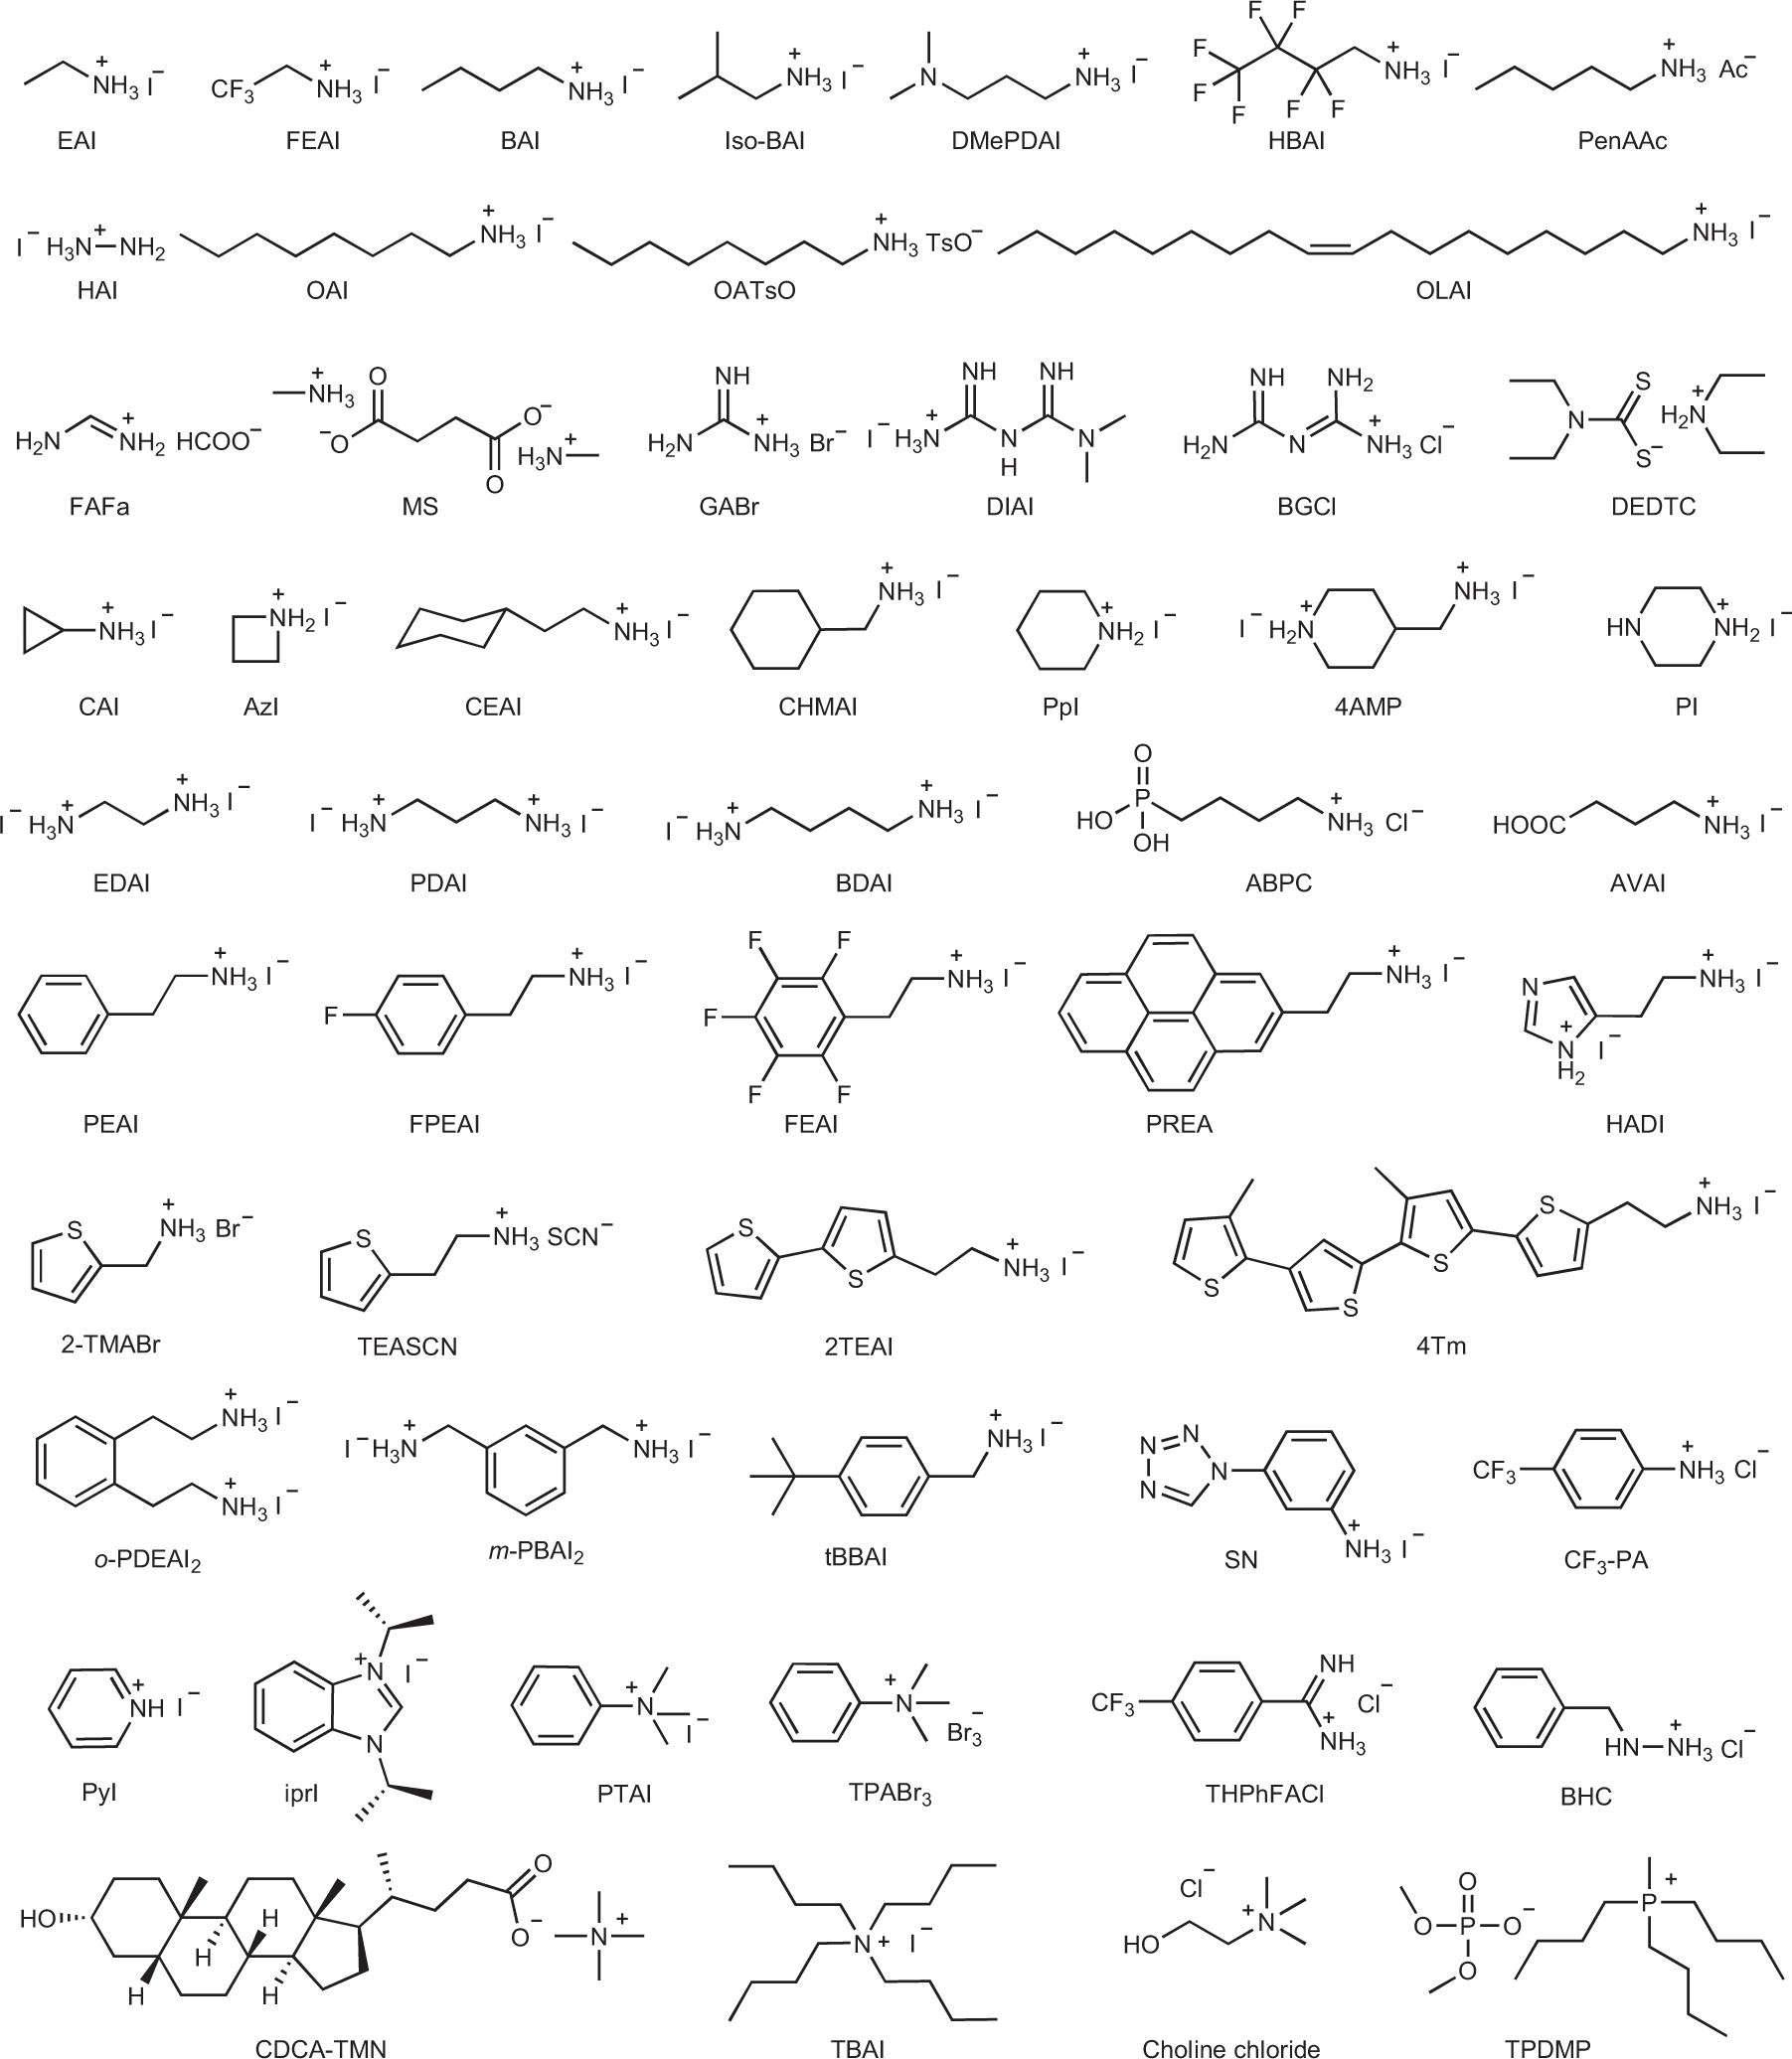 


![/Users/paramvir/Downloads/Figure_5_Hong/CF3-PA.png]

In [ ]:
# Install requirements
# !pip install decimer

## Convert image to molecules 

C[N+](C)(C)CC(Cl)O


/Users/paramvir/miniconda3/lib/python3.8/site-packages/ase/data/pubchem.py:80: UserWarning: The structure "C[N+](C)(C)CC(Cl)O" has more than one conformer in PubChem. By default, the first conformer is returned, please ensure you are using the structure you intend to or use the `ase.data.pubchem.pubchem_conformer_search` function
  warnings.warn(


<Axes: >

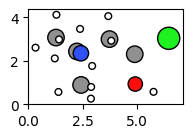

In [17]:
from DECIMER import predict_SMILES
from ase.data.pubchem import pubchem_atoms_search, pubchem_atoms_conformer_search

image_path = "/Users/paramvir/Downloads/Figure_5_Hong/Choline_chloride.png"

SMILES = predict_SMILES(image_path)

split_smiles = SMILES.split(sep='.')

CF3_PA = pubchem_atoms_search(smiles=split_smiles[0])

print(SMILES)

fig, axes = plt.subplots(1, 1, figsize=(2, 2))
plot_atoms(CF3_PA, axes, radii=0.5, rotation=('0x,0y,0z'))

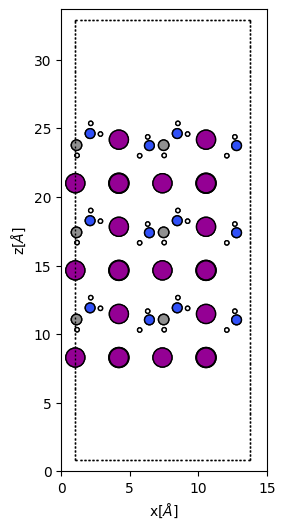

In [14]:
unit_cell = io.read('../FAPbI3/3C.vasp')
unit_cell = unit_cell.repeat((2,2,1))

from ase.visualize import view

import ipywidgets


miller_index = (0, 0, 1) 
n_layers_unit_cell = 6            #  number of unit cells
dist_vacuum = 7.5                 # vacuum above surface

slab_100 = surface(unit_cell, miller_index, n_layers_unit_cell, dist_vacuum, periodic=True)
slab_100 = sort(slab_100)

del slab_100[slab_100.positions[:, 2] > 41]
#remove bottom layers
del slab_100[slab_100.positions[:, 2] < 22]
#supercell =  unit_cell.repeat((1,2,1))

#view(surface)
#print(slab_100.get_cell())

slab_100.center(vacuum=7.5, axis=2)

fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))

plot_atoms(slab_100, ax1, radii=0.5, rotation=('-90x,0y,0z'))
ax1.set_xlim(0, 15)
ax1.set_xlabel(r'x[$\AA$]')
ax1.set_ylabel(r'z[$\AA$]')


view(slab_100)
# write the cell to a vaps file

write_vasp('surface_001.vasp', slab_100, vasp5=True, direct=True)


In [15]:
slab_100

Atoms(symbols='C12H60I36N24Pb12', pbc=True, cell=[12.7019996644, 12.7019996644, 32.0657081962653])

In [ ]:
structure = io.read('../FAPbI3/cubic_3R.cif')
structure = sort(structure)
tmp_molecule=[]
j = 0
num_atoms = len(structure.get_chemical_symbols())
i = 0
del_index = []
N_index = []
flag = False

while i < num_atoms:
    if(structure.get_chemical_symbols()[i] == 'C'):
        del_index.append(i)
        molecule = io.read('../FAPbI3/FA.pdb')
        molecule.set_cell(structure.cell)
        xmin = molecule.get_center_of_mass()[0]
        xmax = structure.positions[i, 0]
        ymin = molecule.get_center_of_mass()[1]
        ymax = structure.positions[i, 1]
        zmin = molecule.get_center_of_mass()[2]
        zmax = structure.positions[i, 2]
        molecule.positions += (xmax - xmin, ymax - ymin, zmax - zmin)   
        if j==0:
            tmp_molecule = molecule 
        else:
            tmp_molecule += molecule
        j = j+1
    i = i + 1
    
k = 0
while k < num_atoms:
    if(structure.get_chemical_symbols()[k] == 'N'):
        del_index.append(k)
    k = k + 1

del structure[del_index]  


FA_replaced_structure = structure + tmp_molecule
FA_replaced_structure = sort(FA_replaced_structure)

view (FA_replaced_structure)
FA_replaced_structure

# Replace top atoms with molecules with $N^+$ in at place of monovalent cation

22.9747636662467 8
Molecule penetrates the slab. Adjusting...
22.9747636662467 8


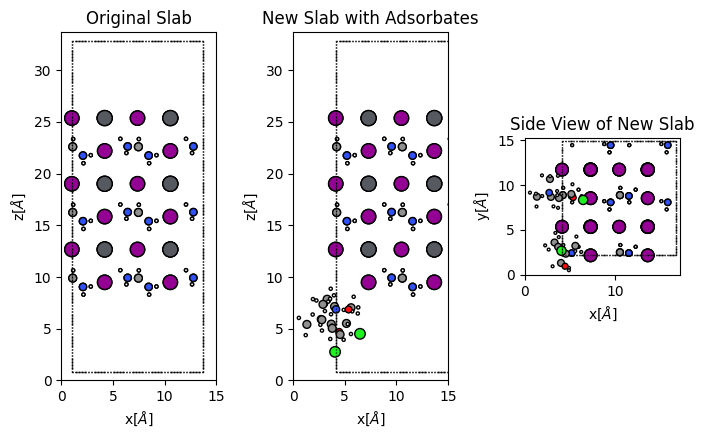

Saved new slab structure to FA_passivations_slab.vasp


In [29]:
import matplotlib.pyplot as plt
import numpy as np
from ase import io
from ase.visualize.plot import plot_atoms
from ase.atoms import Atoms

# Define atomic radii (in Angstroms)
atomic_radii = {
    'Cs': 2.62,
    'N': 1.55,
    'C': 1.70,
    # Add more atomic radii as needed
}

def rotate_molecule_towards_target(molecule, target_position):
    """Rotate the molecule so that nitrogen atoms are oriented towards the target position."""
    nitrogen_indices = [atom.index for atom in molecule if atom.symbol == 'N']
    
    if not nitrogen_indices:
        return

    # Calculate the average position of nitrogen atoms
    nitrogen_positions = molecule.positions[nitrogen_indices]
    avg_nitrogen_pos = np.mean(nitrogen_positions, axis=0)

    # Vector from average nitrogen position to target position
    direction = target_position - avg_nitrogen_pos
    direction[2] = 0  # Only consider x-y plane for rotation
    direction /= np.linalg.norm(direction)

    # Define the direction we want the nitrogen to face (downward)
    target_direction = np.array([0, 0, 1])  # Pointing down

    # Calculate the angle between the current direction and target direction
    angle = np.arccos(np.clip(np.dot(direction, target_direction), -1.0, 1.0))

    # Axis of rotation (cross product)
    rotation_axis = np.cross(direction, target_direction)
    if np.linalg.norm(rotation_axis) == 0:
        return  # No rotation needed

    rotation_axis /= np.linalg.norm(rotation_axis)

    # Create rotation matrix using Rodrigues' rotation formula
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotation_matrix = np.array([
        [cos_angle + rotation_axis[0]**2 * (1 - cos_angle),
         rotation_axis[0] * rotation_axis[1] * (1 - cos_angle) - rotation_axis[2] * sin_angle,
         rotation_axis[0] * rotation_axis[2] * (1 - cos_angle) + rotation_axis[1] * sin_angle],
        [rotation_axis[1] * rotation_axis[0] * (1 - cos_angle) + rotation_axis[2] * sin_angle,
         cos_angle + rotation_axis[1]**2 * (1 - cos_angle),
         rotation_axis[1] * rotation_axis[2] * (1 - cos_angle) - rotation_axis[0] * sin_angle],
        [rotation_axis[2] * rotation_axis[0] * (1 - cos_angle) - rotation_axis[1] * sin_angle,
         rotation_axis[2] * rotation_axis[1] * (1 - cos_angle) + rotation_axis[0] * sin_angle,
         cos_angle + rotation_axis[2]**2 * (1 - cos_angle)]
    ])

    # Rotate the molecule
    molecule.positions = np.dot(molecule.positions - molecule.get_center_of_mass(), rotation_matrix.T) + molecule.get_center_of_mass()

def position_and_rotate_molecule(molecule, slab_position, atomic_radii):
    """Positions and rotates the molecule to bring nitrogen atoms closer to the slab."""
    # Calculate target position for nitrogen atoms
    slab_top = slab_position[2] + atomic_radii['C']  # Top of Cs
    target_z = slab_top + atomic_radii['N'] + 1.0  # Add buffer
    target_position = np.array([slab_position[0], slab_position[1], target_z])

    # Rotate the molecule
    rotate_molecule_towards_target(molecule, target_position)

    # Move the molecule's center of mass to the target position
    center_of_mass = molecule.get_center_of_mass()
    molecule.positions += target_position - center_of_mass

    # Ensure no penetration into the slab
    for atom in molecule:
        if atom.position[2] < slab_top:
            print("Molecule penetrates the slab. Adjusting...")
            adjustment = slab_top - atom.position[2] + 0.1 # Additional space
            molecule.positions[:, 2] += adjustment
            break  # Adjust only once for simplicity

    return molecule

def automate_adsorption(slab_file, molecule_file, num_replace_FA, output_file=None):
    """Automates the adsorption process by replacing specified number of Cs atoms in a slab with a given molecule."""
    try:
        relaxed_slab = io.read(slab_file)
    except Exception as e:
        print(f"Error reading slab file: {e}")
        return

    try:
        molecule = molecule_file
        tmp_molecule = []

        for j in range(num_replace_FA):
            num_atoms = len(relaxed_slab.get_chemical_symbols())
            FA_index = [(relaxed_slab.positions[i, 2], i) 
                         for i in range(num_atoms) 
                         if relaxed_slab.get_chemical_symbols()[i] == 'C']

            if not FA_index:
                print("No FA molecules found for replacement.")
                break

            # Get the index of the Cs atom with the maximum z value
            max_value_z, idz = max(FA_index, key=lambda item: item[0])
            print(max_value_z, idz)

            

            # Position and rotate the molecule
            slab_position = relaxed_slab.positions[idz]

            positioned_molecule = position_and_rotate_molecule(molecule.copy(), slab_position, atomic_radii)

            # Store the positioned molecule and remove the replaced Cs atom
            tmp_molecule = positioned_molecule if j == 0 else tmp_molecule + positioned_molecule

            species='C'

            atom_indices = [i for i, atom in enumerate(relaxed_slab) if atom.symbol == species]
            replacements = random.sample(atom_indices, min(1, len(atom_indices)))
            cutoff_distance=1.2
            nl = NeighborList([cutoff_distance] * len(relaxed_slab), self_interaction=False, bothways=True)
            nl.update(relaxed_slab)
        
            del_indices = []
            for idx in replacements:
                indices, _ = nl.get_neighbors(idz)
                for j in indices:
                    if relaxed_slab[j].symbol == 'N':
                        del_indices.append(j)
                        # Check neighbors of N
                        ind_1, _ = nl.get_neighbors(j)
                        del_indices.extend([k for k in ind_1 if relaxed_slab[k].symbol == 'H'])
               
        
            del relaxed_slab[del_indices]
            del relaxed_slab[idz]

        # Combine the relaxed slab and the new molecule
        new_slab = relaxed_slab + tmp_molecule
        # Visualize the structures
        fig, axes = plt.subplots(1, 3, figsize=(7, 7))
        visualize_structure(slab_file, new_slab, axes)

        # Save the final structure to a VASP file if specified
        if output_file:
            io.write(output_file, new_slab, vasp5=True, direct=True)
            print(f"Saved new slab structure to {output_file}")

    except Exception as e:
        print(f"An error occurred during the process: {e}")

def visualize_structure(slab_file, new_slab, axes):
    """Visualizes the original and new slab structures."""
    slab = io.read(slab_file)
    plot_atoms(slab, axes[0], radii=0.5, rotation=('90x,0y,0z'))
    axes[0].set_xlim(0, 15)
    axes[0].set_xlabel(r'x[$\AA$]')
    axes[0].set_ylabel(r'z[$\AA$]')
    axes[0].set_title('Original Slab')

    plot_atoms(new_slab, axes[1], radii=0.5, rotation=('90x,0y,0z'))
    axes[1].set_xlim(0, 15)
    axes[1].set_xlabel(r'x[$\AA$]')
    axes[1].set_ylabel(r'z[$\AA$]')
    axes[1].set_title('New Slab with Adsorbates')

    plot_atoms(new_slab, axes[2], radii=0.5, rotation=('0x,0y,0z'))
    axes[2].set_xlabel(r'x[$\AA$]')
    axes[2].set_ylabel(r'y[$\AA$]')
    axes[2].set_title('Side View of New Slab')
    #view(new_slab)
    plt.tight_layout()
    plt.show()

# Example usage
molecule_file = CF3_PA  # Replace with your molecule file path

automate_adsorption('surface_001.vasp', molecule_file, num_replace_FA=2, output_file='FA_passivations_slab.vasp')


# Add molecules in CsPbI$_3$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ase import io
from ase.visualize.plot import plot_atoms
from ase.atoms import Atoms

# Define atomic radii (in Angstroms)
atomic_radii = {
    'Cs': 2.62,
    'N': 1.55,
    'C': 1.70,
    # Add more atomic radii as needed
}

def rotate_molecule_towards_target(molecule, target_position):
    """Rotate the molecule so that nitrogen atoms are oriented towards the target position."""
    nitrogen_indices = [atom.index for atom in molecule if atom.symbol == 'N']
    
    if not nitrogen_indices:
        return

    # Calculate the average position of nitrogen atoms
    nitrogen_positions = molecule.positions[nitrogen_indices]
    avg_nitrogen_pos = np.mean(nitrogen_positions, axis=0)

    # Vector from average nitrogen position to target position
    direction = target_position - avg_nitrogen_pos
    direction[2] = 0  # Only consider x-y plane for rotation
    direction /= np.linalg.norm(direction)

    # Define the direction we want the nitrogen to face (downward)
    target_direction = np.array([0, 0, 1])  # Pointing down

    # Calculate the angle between the current direction and target direction
    angle = np.arccos(np.clip(np.dot(direction, target_direction), -1.0, 1.0))

    # Axis of rotation (cross product)
    rotation_axis = np.cross(direction, target_direction)
    if np.linalg.norm(rotation_axis) == 0:
        return  # No rotation needed

    rotation_axis /= np.linalg.norm(rotation_axis)

    # Create rotation matrix using Rodrigues' rotation formula
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotation_matrix = np.array([
        [cos_angle + rotation_axis[0]**2 * (1 - cos_angle),
         rotation_axis[0] * rotation_axis[1] * (1 - cos_angle) - rotation_axis[2] * sin_angle,
         rotation_axis[0] * rotation_axis[2] * (1 - cos_angle) + rotation_axis[1] * sin_angle],
        [rotation_axis[1] * rotation_axis[0] * (1 - cos_angle) + rotation_axis[2] * sin_angle,
         cos_angle + rotation_axis[1]**2 * (1 - cos_angle),
         rotation_axis[1] * rotation_axis[2] * (1 - cos_angle) - rotation_axis[0] * sin_angle],
        [rotation_axis[2] * rotation_axis[0] * (1 - cos_angle) - rotation_axis[1] * sin_angle,
         rotation_axis[2] * rotation_axis[1] * (1 - cos_angle) + rotation_axis[0] * sin_angle,
         cos_angle + rotation_axis[2]**2 * (1 - cos_angle)]
    ])

    # Rotate the molecule
    molecule.positions = np.dot(molecule.positions - molecule.get_center_of_mass(), rotation_matrix.T) + molecule.get_center_of_mass()

def position_and_rotate_molecule(molecule, slab_position, atomic_radii):
    """Positions and rotates the molecule to bring nitrogen atoms closer to the slab."""
    # Calculate target position for nitrogen atoms
    slab_top = slab_position[2] + atomic_radii['Cs']  # Top of Cs
    target_z = slab_top + atomic_radii['N'] + 1.0  # Add buffer
    target_position = np.array([slab_position[0], slab_position[1], target_z])

    # Rotate the molecule
    rotate_molecule_towards_target(molecule, target_position)

    # Move the molecule's center of mass to the target position
    center_of_mass = molecule.get_center_of_mass()
    molecule.positions += target_position - center_of_mass

    # Ensure no penetration into the slab
    for atom in molecule:
        if atom.position[2] < slab_top:
            print("Molecule penetrates the slab. Adjusting...")
            adjustment = slab_top - atom.position[2] + 0.1 # Additional space
            molecule.positions[:, 2] += adjustment
            break  # Adjust only once for simplicity

    return molecule

def automate_adsorption(slab_file, molecule_file, num_replace_Cs, output_file=None):
    """Automates the adsorption process by replacing specified number of Cs atoms in a slab with a given molecule."""
    try:
        relaxed_slab = io.read(slab_file)
    except Exception as e:
        print(f"Error reading slab file: {e}")
        return

    try:
        molecule = molecule_file
        tmp_molecule = []

        for j in range(num_replace_Cs):
            num_atoms = len(relaxed_slab.get_chemical_symbols())
            Cs_index = [(relaxed_slab.positions[i, 2], i) 
                         for i in range(num_atoms) 
                         if relaxed_slab.get_chemical_symbols()[i] == 'Cs']

            if not Cs_index:
                print("No Cs atoms found for replacement.")
                break

            # Get the index of the Cs atom with the maximum z value
            max_value_z, idz = max(Cs_index, key=lambda item: item[0])

            # Position and rotate the molecule
            slab_position = relaxed_slab.positions[idz]
            positioned_molecule = position_and_rotate_molecule(molecule.copy(), slab_position, atomic_radii)

            # Store the positioned molecule and remove the replaced Cs atom
            tmp_molecule = positioned_molecule if j == 0 else tmp_molecule + positioned_molecule
            del relaxed_slab[idz]

        # Combine the relaxed slab and the new molecule
        new_slab = relaxed_slab + tmp_molecule

        # Visualize the structures
        fig, axes = plt.subplots(1, 3, figsize=(7, 7))
        visualize_structure(slab_file, new_slab, axes)

        # Save the final structure to a VASP file if specified
        if output_file:
            io.write(output_file, new_slab, vasp5=True, direct=True)
            print(f"Saved new slab structure to {output_file}")

    except Exception as e:
        print(f"An error occurred during the process: {e}")

def visualize_structure(slab_file, new_slab, axes):
    """Visualizes the original and new slab structures."""
    slab = io.read(slab_file)
    plot_atoms(slab, axes[0], radii=0.5, rotation=('90x,0y,0z'))
    axes[0].set_xlim(0, 15)
    axes[0].set_xlabel(r'x[$\AA$]')
    axes[0].set_ylabel(r'z[$\AA$]')
    axes[0].set_title('Original Slab')

    plot_atoms(new_slab, axes[1], radii=0.5, rotation=('90x,0y,0z'))
    axes[1].set_xlim(0, 15)
    axes[1].set_xlabel(r'x[$\AA$]')
    axes[1].set_ylabel(r'z[$\AA$]')
    axes[1].set_title('New Slab with Adsorbates')

    plot_atoms(new_slab, axes[2], radii=0.5, rotation=('0x,0y,0z'))
    axes[2].set_xlabel(r'x[$\AA$]')
    axes[2].set_ylabel(r'y[$\AA$]')
    axes[2].set_title('Side View of New Slab')
    view(new_slab)
    plt.tight_layout()
    plt.show()

# Example usage
molecule_file = CF3_PA  # Replace with your molecule file path
automate_adsorption('slab_hexagonal_relaxed.vasp', molecule_file, num_replace_Cs=1, output_file='delta_001_2DMA_top.vasp')


# on top of slab as flat molecule

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ase import io
from ase.visualize.plot import plot_atoms
from ase.atoms import Atoms

# Define atomic radii (in Angstroms)
atomic_radii = {
    'Cs': 2.62,
    'N': 1.55,
    'C': 1.70,
    # Add more atomic radii as needed
}

def rotate_molecule(molecule, angle, axis):
    """Rotates the molecule around a specified axis by a given angle."""
    axis = axis / np.linalg.norm(axis)
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)

    rotation_matrix = np.array([
        [cos_angle + axis[0] ** 2 * (1 - cos_angle), 
         axis[0] * axis[1] * (1 - cos_angle) - axis[2] * sin_angle, 
         axis[0] * axis[2] * (1 - cos_angle) + axis[1] * sin_angle],
        [axis[1] * axis[0] * (1 - cos_angle) + axis[2] * sin_angle, 
         cos_angle + axis[1] ** 2 * (1 - cos_angle), 
         axis[1] * axis[2] * (1 - cos_angle) - axis[0] * sin_angle],
        [axis[2] * axis[0] * (1 - cos_angle) - axis[1] * sin_angle, 
         axis[2] * axis[1] * (1 - cos_angle) + axis[0] * sin_angle, 
         cos_angle + axis[2] ** 2 * (1 - cos_angle)]
    ])

    molecule.positions = np.dot(molecule.positions - molecule.get_center_of_mass(), rotation_matrix.T) + molecule.get_center_of_mass()

def position_and_rotate_molecule(molecule, slab_position, atomic_radii):
    """Positions and rotates the molecule to bring nitrogen atoms closer to the slab."""
    # Move the molecule's center of mass to the slab position
    center_of_mass = molecule.get_center_of_mass()
    
    # Calculate target z position: slab top + nitrogen radius + buffer
    slab_top = slab_position[2] + atomic_radii['Cs']  # Highest point of Cs
    target_z = slab_top + atomic_radii['N'] + 1.0  # 1.0 Å buffer

    # Move the molecule's center of mass to the target position
    molecule.positions += np.array([0, 0, target_z - center_of_mass[2]])

    # Find nitrogen atoms and their positions
    nitrogen_indices = [atom.index for atom in molecule if atom.symbol == 'N']
    nitrogen_positions = molecule.positions[nitrogen_indices]

    # Check for any nitrogen atoms that still penetrate the slab
    for pos in nitrogen_positions:
        if pos[2] < slab_top:
            print("Nitrogen atom penetrates the slab. Adjusting...")
            adjustment = slab_top - pos[2] + 0.1  # Additional space
            molecule.positions[:, 2] += adjustment
            break  # Adjust only once for simplicity

    return molecule

def automate_adsorption(slab_file, molecule_file, num_replace_Cs=2, output_file=None):
    """Automates the adsorption process by replacing specified number of Cs atoms in a slab with a given molecule."""
    try:
        relaxed_slab = io.read(slab_file)
    except Exception as e:
        print(f"Error reading slab file: {e}")
        return

    try:
        molecule = molecule_file
        tmp_molecule = []

        for j in range(num_replace_Cs):
            num_atoms = len(relaxed_slab.get_chemical_symbols())
            Cs_index = [(relaxed_slab.positions[i, 2], i) 
                         for i in range(num_atoms) 
                         if relaxed_slab.get_chemical_symbols()[i] == 'Cs']

            if not Cs_index:
                print("No Cs atoms found for replacement.")
                break

            # Get the index of the Cs atom with the maximum z value
            max_value_z, idz = max(Cs_index, key=lambda item: item[0])

            # Position and rotate the molecule
            slab_position = relaxed_slab.positions[idz]
            positioned_molecule = position_and_rotate_molecule(molecule.copy(), slab_position, atomic_radii)

            # Store the positioned molecule and remove the replaced Cs atom
            tmp_molecule = positioned_molecule if j == 0 else tmp_molecule + positioned_molecule
            del relaxed_slab[idz]

        # Combine the relaxed slab and the new molecule
        new_slab = relaxed_slab + tmp_molecule

        # Visualize the structures
        fig, axes = plt.subplots(1, 3, figsize=(7, 7))
        visualize_structure(slab_file, new_slab, axes)

        # Save the final structure to a VASP file if specified
        if output_file:
            io.write(output_file, new_slab, vasp5=True, direct=True)
            print(f"Saved new slab structure to {output_file}")

    except Exception as e:
        print(f"An error occurred during the process: {e}")

def visualize_structure(slab_file, new_slab, axes):
    """Visualizes the original and new slab structures."""
    slab = io.read(slab_file)
    plot_atoms(slab, axes[0], radii=0.5, rotation=('90x,0y,0z'))
    axes[0].set_xlim(-20, 30)
    axes[0].set_xlabel(r'x[$\AA$]')
    axes[0].set_ylabel(r'z[$\AA$]')
    axes[0].set_title('Original Slab')

    plot_atoms(new_slab, axes[1], radii=0.5, rotation=('90x,0y,0z'))
    axes[1].set_xlim(-20, 30)
    axes[1].set_xlabel(r'x[$\AA$]')
    axes[1].set_ylabel(r'z[$\AA$]')
    axes[1].set_title('New Slab with Adsorbates')

    plot_atoms(new_slab, axes[2], radii=0.5, rotation=('0x,0y,0z'))
    view(new_slab)
    axes[2].set_xlabel(r'x[$\AA$]')
    axes[2].set_ylabel(r'y[$\AA$]')
    axes[2].set_title('Side View of New Slab')

    plt.tight_layout()
    plt.show()

# Example usage
molecule_file = CF3_PA  # Replace with your molecule file path
automate_adsorption('slab_hexagonal_relaxed.vasp', molecule_file, num_replace_Cs=2, output_file='delta_001_2DMA_top.vasp')